<a href="https://colab.research.google.com/github/assermahmoud99/internship-tasks/blob/main/Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Downloading the Dataset from Kaggle

Here I used KaggleHub to automatically download the Fake and Real News Dataset.

*   The dataset comes with two separate files: one for true news and one for fake news.
*   I stored their paths in path_true and path_fake for loading later with pandas.



In [ ]:
import kagglehub
# Download latest version
path_true = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset",path='True.csv')
path_fake = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset",path='Fake.csv')
print("Path to dataset files:", path_true)
print("Path to dataset files:", path_fake)

Using Colab cache for faster access to the 'fake-and-real-news-dataset' dataset.
Using Colab cache for faster access to the 'fake-and-real-news-dataset' dataset.
Path to dataset files: /kaggle/input/fake-and-real-news-dataset/True.csv
Path to dataset files: /kaggle/input/fake-and-real-news-dataset/Fake.csv


# 1. Loading the Data and Labeling



*   2,000 rows were loaded each of real and fake news to keep the dataset small for faster experimentation.

*   Assigned label 1 to true news and 0 to fake news.
*   Combined them into a single dataframe df.


*   This creates a balanced dataset to train the classifier.















In [ ]:
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt


true_df = pd.read_csv(path_true,nrows=2000) #extracting the data
fake_df = pd.read_csv(path_fake,nrows=2000)
true_df['label'] = 1
fake_df['label'] = 0
df = pd.concat([true_df,fake_df],axis=0).reset_index(drop=True)
print(df.head())

                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
3  December 30, 2017       1  
4  December 29, 2017       1  


# 2. Preprocessing Text with spaCy



*   Combined the title and text columns into a single content column.

*   Applied spaCy preprocessing: removed stopwords/punctuation and reduced words to their lemmas.

*   This ensures cleaner, more uniform text before vectorization.









In [ ]:
df['content'] = df['title'].fillna("") + ' ' + df['text'].fillna("")
df['label'] = pd.to_numeric(df['label'], errors='coerce')
print(df['label'].value_counts())
nlp = spacy.load('en_core_web_sm')
tokens = []
def clean_text(news):
  doc = nlp(news)
  tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
  return " ".join(tokens)
df['cotent'] = df['content'].astype(str).apply(clean_text)
df['content'].head(10)


label
1    2000
0    2000
Name: count, dtype: int64


,content
0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...
5,"White House, Congress prepare for talks on spe..."
6,"Trump says Russia probe will be fair, but time..."
7,Factbox: Trump on Twitter (Dec 29) - Approval ...
8,Trump on Twitter (Dec 28) - Global Warming The...
9,Alabama official to certify Senator-elect Jone...


# 3. Feature Extraction and Logistic Regression


*   Split data into train (80%) and test (20%).

*   Used TF-IDF vectorization with 20,000 features and both unigrams/bigrams.
*   Trained a Logistic Regression classifier.


*   Evaluated using confusion matrix, accuracy, and classification report.
This gives the baseline performance for detecting fake vs real news.










In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df['content'],df['label'],test_size=0.2,random_state=42)

vecotrizer = TfidfVectorizer(stop_words='english',max_features=20000,ngram_range=(1,2))
X_train_vec = vecotrizer.fit_transform(X_train)
X_test_vec = vecotrizer.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train_vec, y_train)
y_pred = lr.predict(X_test_vec)
print(lr.coef_)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[-0.05312717  0.46456622  0.00295465 ...  0.04314551  0.06679331
   0.03935375]]
[[374   4]
 [  3 419]]
0.99125
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       378
           1       0.99      0.99      0.99       422

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



# 4. Bonus: WordCloud Visualization

generated WordClouds for both fake and true news to visually explore the most frequent words.


*   Red cloud = Fake news → often highlights emotional or clickbait-style words.
*   Blue cloud = True news → tends to show more factual, formal terms.


This visualization provides an interpretability bonus alongside numeric evaluation.







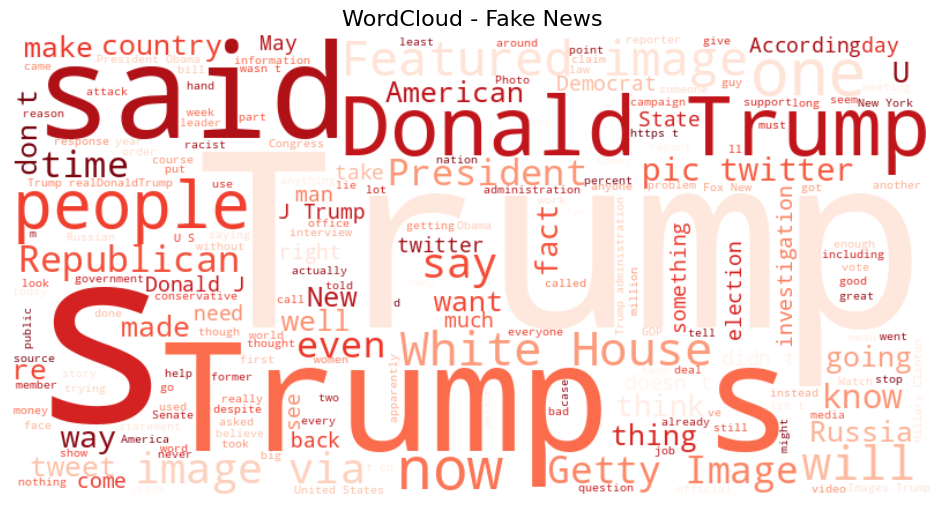

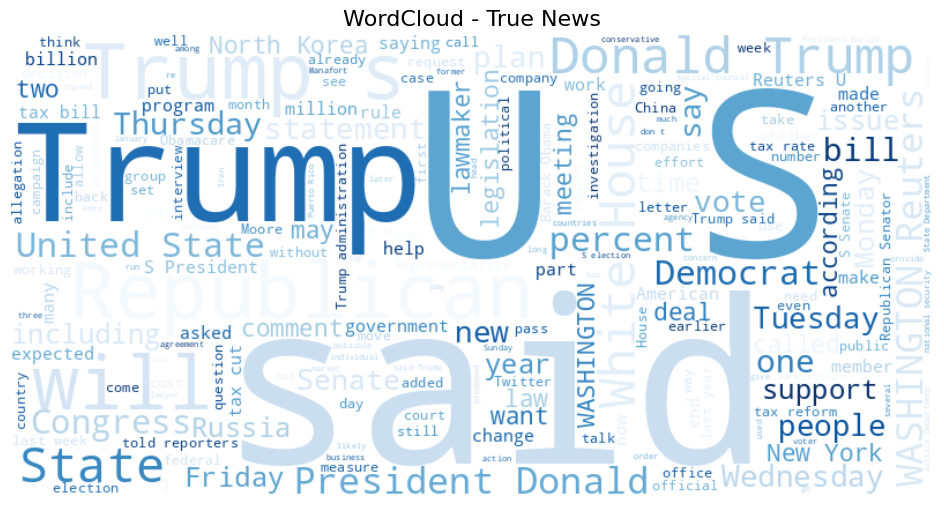

In [ ]:
# Fake news
fake_text = " ".join(df[df["label"] == 0]["content"].astype(str).values)

wordcloud_fake = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(fake_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Fake News", fontsize=16)
plt.show()


# True news
true_text = " ".join(df[df["label"] == 1]["content"].astype(str).values)

wordcloud_true = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate(true_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_true, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - True News", fontsize=16)
plt.show()
